In [25]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [26]:
dataset = pd.read_csv("corporate_messaging_dfe.csv")

In [27]:
dataset.head()



,unit_id,golden,unit_state,trusted_judgments,last_judgment_at,category,category_confidence,category_gold,id,screenname,text
0,662822308,False,finalized,3,2015-02-18T04:31:00,Information,1.0,NaN,436528000000000000,Barclays,Barclays CEO stresses the importance of regula...
1,662822309,False,finalized,3,2015-02-18T13:55:00,Information,1.0,NaN,386013000000000000,Barclays,Barclays announces result of Rights Issue http...
2,662822310,False,finalized,3,2015-02-18T08:43:00,Information,1.0,NaN,379580000000000000,Barclays,Barclays publishes its prospectus for its �5.8...
3,662822311,False,finalized,3,2015-02-18T09:13:00,Information,1.0,NaN,367530000000000000,Barclays,Barclays Group Finance Director Chris Lucas is...
4,662822312,False,finalized,3,2015-02-18T06:48:00,Information,1.0,NaN,360385000000000000,Barclays,Barclays announces that Irene McDermott Brown ...


In [28]:
dataset.shape


(3118, 11)

In [29]:
dataset['category'].value_counts()

Information    2129
Action          724
Dialogue        226
Exclude          39
Name: category, dtype: int64

In [30]:
dataset['category_confidence'].value_counts()

1.0000    2430
0.6614      35
0.6643      33
0.6747      32
0.6775      29
          ... 
0.8547       1
0.6641       1
0.8578       1
0.9089       1
0.8245       1
Name: category_confidence, Length: 194, dtype: int64

In [31]:
dataset = dataset[(dataset['category_confidence'] == 1) & (dataset['category'] != 'Exclude')]


In [32]:
features = dataset['text']
target = dataset['category']


In [33]:
features[0]

'Barclays CEO stresses the importance of regulatory and cultural reform in financial services at Brussels conference  http://t.co/Ge9Lp7hpyG'

In [34]:

features[2]

'Barclays publishes its prospectus for its �5.8bn Rights Issue: http://t.co/YZk24iE8G6'

In [35]:

import re
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')

stopword = stopwords.words('english')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

non_ascii_regex = r'[^\x00-\x7F]+'

def tokenize(text):
    
    text = re.sub(url_regex, 'urlplaceholder', text)
    
    text = re.sub(non_ascii_regex , ' ', text)

    tokens = word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()

    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopword]

    return clean_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Electrobot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Electrobot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


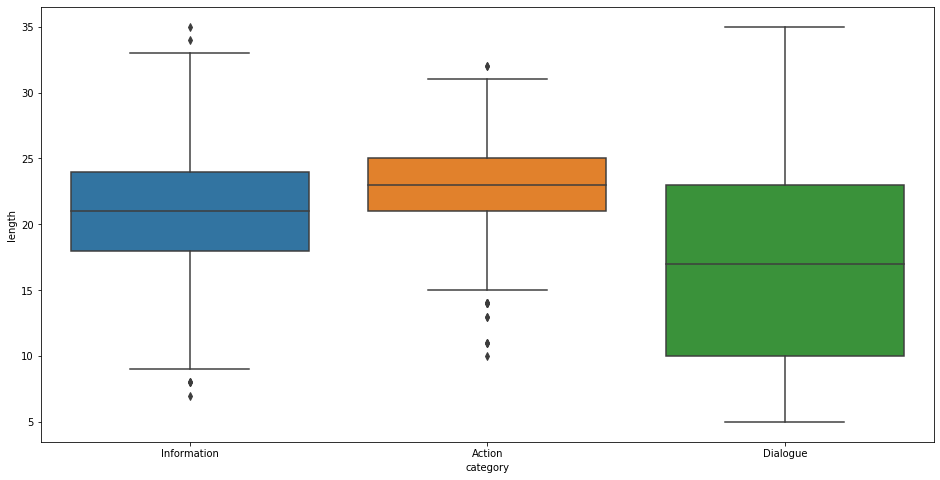

In [36]:
nltk.download('punkt')

dataset['length'] = dataset['text'].apply(lambda x : len(word_tokenize(x)))

fig = plt.figure(figsize = (16,8))
sns.boxplot(x='category',y='length', data = dataset)


In [37]:

dataset['url_count'] = dataset['text'].apply(lambda x : len(re.findall(url_regex, x)))

pd.crosstab(dataset['category'],dataset['url_count'], normalize  =True)

url_count,0,1,2
category,,,
Action,0.014565,0.166042,0.009155
Dialogue,0.032876,0.018727,0.000000
Information,0.205576,0.533916,0.019143


In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class LengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def compute_length(self, text):
        sentence_list = len(word_tokenize(text))
        return sentence_list
        
    def transform(self, x):
        x_length = pd.Series(x).apply(self.compute_length)
        return pd.DataFrame(x_length)

In [39]:

class URLCounter(BaseEstimator, TransformerMixin):
    def fit(self, x, y = None):
        return self
    
    def counturl(self, x):
        urls = re.findall(url_regex, x)
        return len(urls)
    
    def transform(self, x):
        url_count = pd.Series(x).apply(self.counturl)
        return pd.DataFrame(url_count)


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [50]:

pipeline = Pipeline([
    
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),
           
            ('text_len', LengthExtractor()),
            
            ('url_counts', URLCounter())
        ])),

        ('clf', RandomForestClassifier(verbose=True))
], verbose =True)


In [51]:

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, random_state =46)

In [52]:
nltk.download('wordnet')
pipeline.fit(xtrain,ytrain)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Electrobot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[Pipeline] .......... (step 1 of 2) Processing features, total=   0.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [53]:
y_pred = pipeline.predict(xtest)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


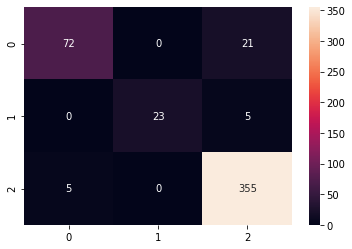

In [54]:

from sklearn.metrics import confusion_matrix

labels = np.unique(y_pred)

sns.heatmap(confusion_matrix(ytest, y_pred, labels = labels), annot=True, fmt='.0f')

In [55]:

from sklearn.metrics import classification_report


print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

      Action       0.94      0.77      0.85        93
    Dialogue       1.00      0.82      0.90        28
 Information       0.93      0.99      0.96       360

    accuracy                           0.94       481
   macro avg       0.96      0.86      0.90       481
weighted avg       0.94      0.94      0.93       481

